In [0]:
%pip install --upgrade tables
%pip install eli5
%pip install xgboost
%pip install hyperopt


     |████████████████████████████████| 4.3MB 4.9MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 4.9MB/s 


In [0]:
import pandas as pd
import numpy as np

import xgboost as xgb

import eli5

In [0]:
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.model_selection import cross_val_score
from eli5.sklearn import PermutationImportance

In [0]:
from hyperopt import hp, fmin, tpe, STATUS_OK

In [31]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/matrix/matrix_two/dw_matrix_car/
%ls

/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/dw_matrix_car
data/                     day3_simple_model.ipynb  day5.ipynb  README.md
day2_visualisation.ipynb  day4.ipynb               LICENSE


In [32]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

## Features Engineering

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0], list): continue # skip list columns
  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat: # guard against multiply restarts of this notebook
    df[feat] = factorized_values
  else:
    df[feat + SUFFIX_CAT] = factorized_values

cat_feats0 = [x for x in df.columns if SUFFIX_CAT in x]
cat_feats = [x for x in cat_feats0 if 'price' not in x]
len(cat_feats)

df['param_rok-produkcji_NUM'] = df['param_rok-produkcji'].map(lambda r: -1 if r is None else int(r))
df['param_moc_NUM'] = df['param_moc'].map(lambda x: -1 if x is None else int(x.split(' ')[0]) )
df['param_pojemność-skokowa_NUM'] = df['param_pojemność-skokowa'].map(lambda x: -1 if x is None else int(x.split('cm')[0].replace(' ','')) )

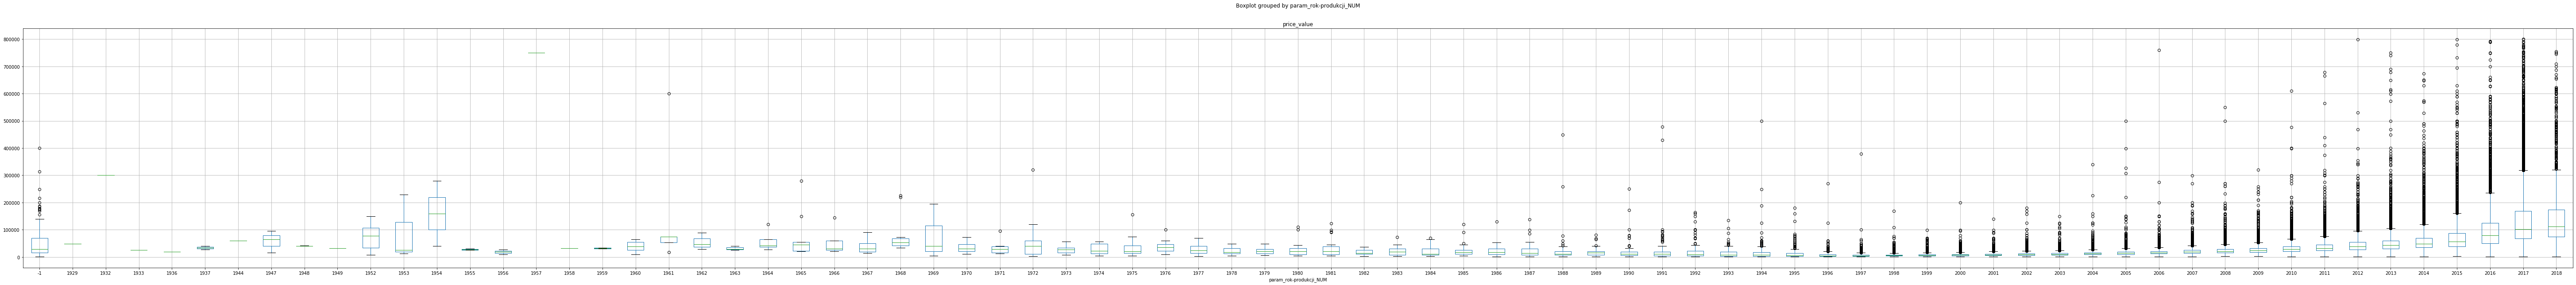

In [34]:
df.boxplot(column='price_value',by='param_rok-produkcji_NUM', figsize=(100,10)) 

In [0]:
def run_model(model, feats):
  X = df[ feats].values
  y = df.price_value.values
  scores = cross_val_score(model, X, y, cv = 3, scoring='neg_mean_absolute_error') # runs fit and cross-validation
  return np.mean(scores), np.std(scores)

In [0]:
feats4 = ['param_stan__cat',
'param_rok-produkcji_NUM',
'param_napęd__cat',
'param_faktura-vat__cat',
'param_moc_NUM',
'param_skrzynia-biegów__cat',
'param_marka-pojazdu__cat',
'feature_kamera-cofania__cat',
'param_typ__cat',
'param_pojemność-skokowa_NUM',
'seller_name__cat',
'param_wersja__cat',
'feature_wspomaganie-kierownicy__cat',
'param_model-pojazdu__cat',
'feature_system-start-stop__cat',
'param_kod-silnika__cat',
'feature_asystent-pasa-ruchu__cat',
'feature_łopatki-zmiany-biegów__cat',
'feature_światła-led__cat',
'feature_czujniki-parkowania-przednie__cat']

xgb_params ={'max_depth':5, 'n_estimators':50, 'learning_rate':0.1, 'seed':0}

In [37]:
run_model(xgb.XGBRegressor(**xgb_params, objective="reg:squarederror"), feats4)

(-9556.386833712553, 101.95145044301204)

## Hyperopt

In [0]:
def objective_func(params):
  print("Training with params: ")
  print(params)
  mean_mae, score_std = run_model(xgb.XGBRegressor(**params),feats4)
  return {'loss': np.abs(mean_mae), 'status': STATUS_OK}

In [0]:
# parameter space
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
    'subsample':        hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'objective':        'reg:squarederror',
    'n_estimators':     100,
    'seed': 0,
}

In [42]:
best = fmin(objective_func, xgb_reg_params, algo = tpe.suggest, max_evals=25)
best

Training with params: 
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.75}
Training with params: 
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'max_depth': 14, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.9500000000000001}
Training with params: 
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.6000000000000001}
Training with params: 
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'max_depth': 14, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.7000000000000001}
Training with params: 
{'colsample_bytree': 1.0, 'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 100, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.75}
Training with params: 
{'colsample_bytree': 0.5

{'colsample_bytree': 0.9, 'learning_rate': 3, 'max_depth': 4, 'subsample': 1.0}